<table  align="left" width="100%"> <tr>
        <td  style="background-color:#ffffff;"><a href="https://qworld.net" target="_blank"><img src="../images/qworld.jpg" width="35%" align="left"></a></td>
        <td  align="right" style="background-color:#ffffff;vertical-align:bottom;horizontal-align:right">
            prepared by <a href="https://iitis.pl/pl/person/aglos" target="_blank"  >Adam Glos</a>
        </td>        
</tr></table>

# Grover's Algorithm revisited

Grover's Search is one of the well-known quantum algorithms. Given an oracle which marks some of the elements in the search space, Grover's Algrorithm outputs the marked elements with high probability. This notebook only serves as a recap for Grover's Search and presents the code in Cirq. We refer to Bronze for the actual explanation of the algorithm.

The quantum circuit for the algorithm takes the form:

<img src="../images/grover.png" width="60%" align="center">

Oracle is responsible for marking the elements, while Grover diffusion operator amplifies the probability of measuring the marked elements. They are applied interchangeably for $\sqrt{N/k}$ times, where $N$ is the size of the search space, and $k$ is the number of marked elements.

## Initialization 

The Grover's search starts with creating an equal superposition on all qubits. We start with implementing this step of the algorithm.

### Task 1 
Create a 4-qubit circuit named `circuit` and apply a Hadamard gate on each qubit. Convince yourself about the correctness of the circuit by displaying it. Print the quantum state with `Simulator` without measurement.

In [1]:
import cirq

# create the circuit
circuit = cirq.Circuit()
qubits = cirq.LineQubit.range(4)
circuit.append(cirq.H.on_each(*qubits))

# for displaying the circuit
print(circuit)

# to print the state
s = cirq.Simulator()
print(s.simulate(circuit))
print(s.simulate(circuit).dirac_notation())

0: ───H───

1: ───H───

2: ───H───

3: ───H───
measurements: (no measurements)

qubits: (cirq.LineQubit(0),)
output vector: 0.707|0⟩ + 0.707|1⟩

qubits: (cirq.LineQubit(1),)
output vector: 0.707|0⟩ + 0.707|1⟩

qubits: (cirq.LineQubit(2),)
output vector: 0.707|0⟩ + 0.707|1⟩

qubits: (cirq.LineQubit(3),)
output vector: 0.707|0⟩ + 0.707|1⟩

phase:
output vector: |⟩
0.25|0000⟩ + 0.25|0001⟩ + 0.25|0010⟩ + 0.25|0011⟩ + 0.25|0100⟩ + 0.25|0101⟩ + 0.25|0110⟩ + 0.25|0111⟩ + 0.25|1000⟩ + 0.25|1001⟩ + 0.25|1010⟩ + 0.25|1011⟩ + 0.25|1100⟩ + 0.25|1101⟩ + 0.25|1110⟩ + 0.25|1111⟩


## A simple oracle

Here we will design a simple oracle, which marks the state $\ket{1111}$. Here marking means to change the sign of state $\ket{1111}$ to $-\ket{1111}$, while leaving the other states unchanged. We know that the operator

$$ Z = \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix}$$

changes the state $\ket{1}$ into $-\ket{1}$. Even though stand-alone $Z$ gate applied to the third qubit changes the state $\ket{1111}$ into -$\ket{1111}$, it also changes, for example, the state $\ket{0011}$ into -$\ket{0011}$. On the other hand, we can design a multi-controlled $Z$ gate for our purpose: $Z$ gate is activated on the third qubit when the other qubits are in states $\ket{1}$, i.e., $b_0=b_1=b_2 = 1$.


Now we show how to implement this multiple-controlled gate. In order to apply $Z$ gate on the third qubit, we use `cirq.Z(qq[3])` and we control this gate with control on the remaining qubits with `cirq.Z(qq[3]).controlled_by(qq[0], qq[1], qq[2])`.  

In [5]:
import cirq

qq = cirq.LineQubit.range(4)
circuit = cirq.Circuit()

CCCZ = cirq.Z(qq[3]).controlled_by(qq[0], qq[1], qq[2])
# alternative version:
# CCCZ = cirq.Z(qq[3]).controlled_by(*(qq[0:3]))
circuit.append(CCCZ)

print(circuit)
print(s.simulate(circuit))
print(s.simulate(circuit).dirac_notation())

0: ───@───
      │
1: ───@───
      │
2: ───@───
      │
3: ───Z───
measurements: (no measurements)

qubits: (cirq.LineQubit(0), cirq.LineQubit(1), cirq.LineQubit(2), cirq.LineQubit(3))
output vector: |0000⟩

phase:
output vector: |⟩
|0000⟩


#### Multi-controlled gates in general

Alternatively, we can define a multi-controlled gate, and specify the target and control qubits later. This will be particularly useful, when the same gate will be used many times on a various collection of qubits.

In [8]:
import cirq

qq = cirq.LineQubit.range(4)
circuit = cirq.Circuit()

CCCZ = cirq.Z.controlled(3)
CCCX = cirq.X.controlled(3)

circuit.append(CCCZ(*qq))
circuit.append(CCCX(*qq))
circuit.append(CCCX(qq[0], qq[1], qq[3], qq[2]))

print(circuit)

0: ───@───@───@───
      │   │   │
1: ───@───@───@───
      │   │   │
2: ───@───@───X───
      │   │   │
3: ───Z───X───@───


Note that for `CCCZ`, the target qubit is not distinguished when displayed. This is because controlled $Z$ operator acts exactly the same independent of the chosen target qubit. This can be easily shown as `CCCZ` acts nontrivially (in case of basis states) only on $\ket{1111}$ -- as you can see there is no way to distinguish which qubit is a target one from this form.

Note that a multi-controlled operator is not the same as several single-qubits controls. To see this, let us simulate the operators for both cases. To do so, we will compare the unitary matrices. To make matrices smaller and easier to compare, we will only compare 3-qubits operations.

In [7]:
import cirq
from cirq import Z

# z gate controlled by qubits 0 and 1
qq = cirq.LineQubit.range(3)
circ_multi = cirq.Circuit()
circ_multi.append(Z(qq[2]).controlled_by(qq[0], qq[1]))

qq = cirq.LineQubit.range(3)
circ_single = cirq.Circuit()
# z gate controlled by qubit 0
circ_single.append(Z(qq[2]).controlled_by(qq[0]))
# z gate controlled by qubit 1
circ_single.append(Z(qq[2]).controlled_by(qq[1]))

print(cirq.unitary(circ_multi))
print()
print(cirq.unitary(circ_single))

[[ 1.+0.0000000e+00j  0.+0.0000000e+00j  0.+0.0000000e+00j
   0.+0.0000000e+00j  0.+0.0000000e+00j  0.+0.0000000e+00j
   0.+0.0000000e+00j  0.+0.0000000e+00j]
 [ 0.+0.0000000e+00j  1.+0.0000000e+00j  0.+0.0000000e+00j
   0.+0.0000000e+00j  0.+0.0000000e+00j  0.+0.0000000e+00j
   0.+0.0000000e+00j  0.+0.0000000e+00j]
 [ 0.+0.0000000e+00j  0.+0.0000000e+00j  1.+0.0000000e+00j
   0.+0.0000000e+00j  0.+0.0000000e+00j  0.+0.0000000e+00j
   0.+0.0000000e+00j  0.+0.0000000e+00j]
 [ 0.+0.0000000e+00j  0.+0.0000000e+00j  0.+0.0000000e+00j
   1.+0.0000000e+00j  0.+0.0000000e+00j  0.+0.0000000e+00j
   0.+0.0000000e+00j  0.+0.0000000e+00j]
 [ 0.+0.0000000e+00j  0.+0.0000000e+00j  0.+0.0000000e+00j
   0.+0.0000000e+00j  1.+0.0000000e+00j  0.+0.0000000e+00j
   0.+0.0000000e+00j  0.+0.0000000e+00j]
 [ 0.+0.0000000e+00j  0.+0.0000000e+00j  0.+0.0000000e+00j
   0.+0.0000000e+00j  0.+0.0000000e+00j  1.+0.0000000e+00j
   0.+0.0000000e+00j  0.+0.0000000e+00j]
 [ 0.+0.0000000e+00j  0.+0.0000000e+00j  0.+0.

Note that only the former has single $-1$ on the bottom-right corner (`j` stands for the imaginary unit).

## The Grover's diffusion operator

The Grover's diffusion (inversion) operator plays a vital role in the algorithm, as it amplifies the amplitude(s) of the marked element(s) if applied for correct number of times. It can be presented by the following unitary matrix:

$$I-2 \begin{pmatrix}
  \frac{1}{N} & \cdots & \frac{1}{N} \\
  \vdots & \ddots & \vdots \\
  \frac{1}{N} & \cdots & \frac{1}{N}
\end{pmatrix} ,$$

where $N$ is the dimension of the matrix. The implementation of this operator is known. Here is an example circuit given for four qubits $(N = 16)$.

<img src="..\images/grover_diffusion_operator.png" width="40%" align="center">

In general, one can apply Hadamard and $NOT$ gates to each qubit, and then use a multi-controlled $Z$ gate followed by the same $NOT$ and Hadamard gates. 

Please check the end of the notebook to read about why those gates are used to implement the diffusion operator.

### Task 2 
    
Create a 3-qubit register and design the Grover diffusion operator based on the circuit above. Print the circuit and its matrix form by using `cirq.unitary`. Verify that the circuit by checking the entries of the matrix.

In [10]:
import cirq
from cirq import H, X, Z

# create the circuit
qq = cirq.LineQubit.range(3)
circuit = cirq.Circuit()
circuit.append(H.on_each(*qq))
circuit.append(X.on_each(*qq))
circuit.append(Z(qq[2]).controlled_by(qq[0], qq[1]))
circuit.append(X.on_each(*qq))
circuit.append(H.on_each(*qq))

# display the circuit
print(circuit)

# Print the unitary matrix. Note that on the entries on the diagonal should equal 1-2/N = 3/4, 
# while for the outer-diagonal it should be -2/N = 1/4 =0.125

N = 2**3
print("On the diagonal:", 1-2/N)
print("Outside the main diagonal:", -2/N, "\n")
print(cirq.unitary(circuit))

0: ───H───X───@───X───H───
              │
1: ───H───X───@───X───H───
              │
2: ───H───X───@───X───H───
On the diagonal: 0.75
Outside the main diagonal: -0.25 

[[ 0.75+1.5308085e-17j -0.25+1.5308085e-17j -0.25+1.5308085e-17j
  -0.25+1.5308085e-17j -0.25+1.5308085e-17j -0.25+1.5308085e-17j
  -0.25+1.5308085e-17j -0.25+1.5308085e-17j]
 [-0.25+1.5308085e-17j  0.75+1.5308085e-17j -0.25+1.5308085e-17j
  -0.25+1.5308085e-17j -0.25+1.5308085e-17j -0.25+1.5308085e-17j
  -0.25+1.5308085e-17j -0.25+1.5308085e-17j]
 [-0.25+1.5308085e-17j -0.25+1.5308085e-17j  0.75+1.5308085e-17j
  -0.25+1.5308085e-17j -0.25+1.5308085e-17j -0.25+1.5308085e-17j
  -0.25+1.5308085e-17j -0.25+1.5308085e-17j]
 [-0.25+1.5308085e-17j -0.25+1.5308085e-17j -0.25+1.5308085e-17j
   0.75+1.5308085e-17j -0.25+1.5308085e-17j -0.25+1.5308085e-17j
  -0.25+1.5308085e-17j -0.25+1.5308085e-17j]
 [-0.25+1.5308085e-17j -0.25+1.5308085e-17j -0.25+1.5308085e-17j
  -0.25+1.5308085e-17j  0.75+1.5308085e-17j -0.25+1.5308085e-17j


## Grover's Algorithm

Finally, we are ready to implement the Grover's Algorithm. Let us consider the Grover's Search for four qubits with proposed simplified oracle. We make an initialization, then apply the oracle (the one we prepared before) and the diffusion operator alternately for $\pi\sqrt{2^4}/4\approx 3$ times. Eventually, the state 1111 should be measured more often than the other basis states. 

### Task 3

Fill the `oracle` and `grover_diffusion` so that they will form a 4-qubit Grover's algorithm. You can use the code from previous tasks. Verify the results by analyzing the statistics of the measurements. Note you can use `yield` for sending consecutive gates. 

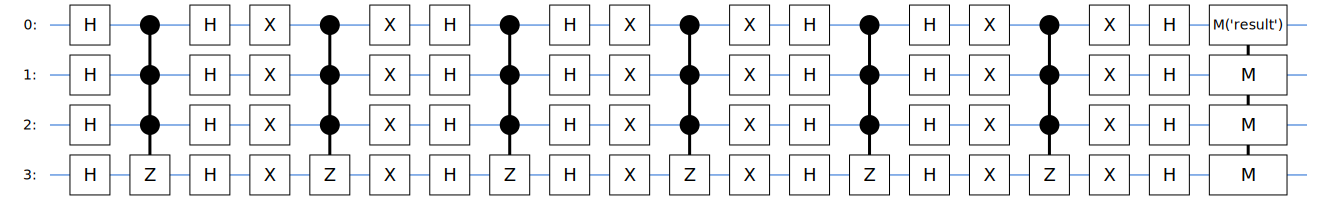

In [21]:
import cirq
from cirq.contrib.svg import SVGCircuit
from cirq import H, Z, X

qq = cirq.LineQubit.range(4)
circuit = cirq.Circuit()
circuit.append(H.on_each(*qq))

def oracle():
    yield Z(qq[3]).controlled_by(*(qq[0:3]))


def grover_diffusion():
    yield H.on_each(*qq)
    yield X.on_each(*qq)
    yield Z(qq[3]).controlled_by(*(qq[0:3]))
    yield X.on_each(*qq)
    yield H.on_each(*qq)

for i in range(3):
    circuit.append(oracle())
    circuit.append(grover_diffusion())


circuit.append(cirq.measure(*qq, key='result'))

SVGCircuit(cirq.Circuit(circuit))
    

In [22]:
# determine the statistics of the measurements
s = cirq.Simulator() 
trials_number = 1000
samples = s.run(circuit, repetitions=trials_number)

def bitstring(bits):
    return "".join(str(int(b)) for b in bits)

counts = samples.histogram(key="result",fold_func=bitstring)

print("Measurement output: ", counts)
print("Probability of measuring 1111: ", counts.get('1111')/trials_number)
print("Probability of not measuring 1111: ", 1- counts.get('1111')/trials_number)

Measurement output:  Counter({'1111': 957, '0111': 7, '0101': 4, '1011': 4, '1100': 4, '0011': 3, '1001': 3, '0100': 3, '0110': 3, '0001': 3, '1101': 2, '0000': 2, '1000': 2, '1010': 1, '0010': 1, '1110': 1})
Probability of measuring 1111:  0.957
Probability of not measuring 1111:  0.04300000000000004


## Are we done?

We have just implemented the Grover's search algorithm finding 1111 label in $\approx \pi\sqrt{N}/4$ time. In this example, we have implemented a very simple oracle which required using the knowledge about the element we were searching for.

In the next notebooks, we will implement less trivial oracles and use Grover's Algorithm to help us in finding out the solution of a harder problem.

----

<h2>Why these gates are chosen? (Optional) </h2>

Now let's try to understand why these gates are chosen. Let's recall the diffusion operator:

$$2 \begin{bmatrix}
  \frac{1}{N} & \cdots & \frac{1}{N} \\
  \vdots & \ddots & \vdots \\
  \frac{1}{N} & \cdots & \frac{1}{N}
\end{bmatrix} - I .$$

Recall that the diffusion operator can be expressed as $D=2\ket{u}\bra{u}-I$ where $\ket{u}=H^{\otimes n}\ket{0^n}$ is the equal superposition vector. We will simply denote $\ket{0^n}$ by $\ket{\mathbf{0}}$. 


Instead of $D$, we will implement $-D$. Since the two operators differ by a negative sign, they yield the same observation probabilities. 

For instance, if $D \ket{\psi} = \ket{\phi}$, then $-D \ket{\psi} = -\ket{\phi}$ and the states $\ket{\phi}$ and $-\ket{\phi}$ have identical observation probabilities.

- To start with let's express $-D$ as follows:

\begin{align*}
-D=-(2\ket{u}\bra{u}-I) = I - 2\ket{u}\bra{u} &= I - 2(H^{\otimes n}\ket{\mathbf{0}}\bra{\mathbf{0}}H^{\otimes n}) \\
&= H^{\otimes n}H^{\otimes n} - 2(H^{\otimes n}\ket{\mathbf{0}}\bra{\mathbf{0}}H^{\otimes n})\\
&=H^{\otimes n} (H^{\otimes n} - 2\ket{\mathbf{0}}\bra{\mathbf{0}}H^{\otimes n}) \\
&=H^{\otimes n} (I - 2\ket{\mathbf{0}}\bra{\mathbf{0}})H^{\otimes n}
\end{align*}

<i>Looking at this expression, we understand why we have $H$ gates at the beginning and at the end</i>

- Now let us look at the effect of applying $I - 2\ket{\mathbf{0}}\bra{\mathbf{0}}$ to any arbitrary state.

$(I - 2\ket{\mathbf{0}}\bra{\mathbf{0}}) \ket{x} = \ket{x} - 2\ket{\mathbf{0}}\braket{\mathbf{0}}{x}.$

If $\ket{x}=\ket{\mathbf{0}}$, since $\braket{\mathbf{0}}{\mathbf{0}}=1$, then $ \ket{x} - 2\ket{\mathbf{0}}\braket{\mathbf{0}}{x} = \ket{\mathbf{0}} - 2\ket{\mathbf{0}}\braket{\mathbf{0}}{\mathbf{0}} =\ket{\mathbf{0}} -2\ket{\mathbf{0}} = - \ket{\mathbf{0}}$.

If $\ket{x}\neq \ket{\mathbf{0}}$, since $\braket{\mathbf{0}}{x}=0$, then $ \ket{x} - 2\ket{\mathbf{0}}\braket{\mathbf{0}}{x} =  \ket{x} - 2\ket{\mathbf{0}}\cdot 0  = \ket{x}$.

Hence, the effect of $I - 2\ket{\mathbf{0}}\bra{\mathbf{0}}$ is flipping the amplitude of the state $\ket{\mathbf{0}}$.

- How to check if the quantum state is equal to $\ket{\bf{0}}$ and flip its amplitude?

If all qubits were in state $\ket{1}$, then we could use a multi-controlled $Z$ gate to flip the amplitude. Instead, we need to apply a multi-controlled $Z$ gate when all qubits are in state state $\ket{0}$.

 <i> That's why we first apply $X$ gates and then apply multi-controlled $Z$ gate. Afterwards, we set the qubits back by applying $X$ gates again (Recall the multiple controlled constructions notebook.). </i>